In [1]:
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import Flowers102
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

# список изменений в коде: батчи по памяти, воркеры, датасет из торча

In [14]:
def train_Flowers102(
    n_epoch: int = 100, device: str = "cuda:0", load_pth: Optional[str] = None #  номер куды на 0
) -> None:

    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000) # 3 входных канала, 3 выходных, 128 фич

    if load_pth is not None:
        ddpm.load_state_dict(torch.load("ddpm_Flowers.pth"))

    ddpm.to(device)

    tf = transforms.Compose(
        [ transforms.ToTensor(), transforms.Resize([64,64]), transforms.RandomVerticalFlip(0.1),transforms.RandomHorizontalFlip(0.1) ] ) # добален ресайз и повороты

    dataset = Flowers102(
        "./data",
        download=True,
        transform=tf,
    )

    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0) # батч сайз уменьшил и число работников 0, потому что я на винде работаю
    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            ### break ###
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(8, (3, 64, 64), device) # здесь размер 3*64*64 у торча C*H*W 
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4) 
            save_image(grid, f"./contents/ddpm_sample_Flowers{i}.png") # изменил название

            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_Flowers.pth") # название сохраненных весов изменено





In [15]:
train_Flowers102()

Epoch 0 : 


loss: 0.7768: 100%|██████████| 64/64 [00:20<00:00,  3.19it/s]


Epoch 1 : 


loss: 0.4520: 100%|██████████| 64/64 [00:19<00:00,  3.21it/s]


Epoch 2 : 


loss: 0.2675: 100%|██████████| 64/64 [00:20<00:00,  3.15it/s]


Epoch 3 : 


loss: 0.1870: 100%|██████████| 64/64 [00:19<00:00,  3.22it/s]


Epoch 4 : 


loss: 0.1385: 100%|██████████| 64/64 [00:20<00:00,  3.20it/s]


Epoch 5 : 


loss: 0.1328: 100%|██████████| 64/64 [00:20<00:00,  3.16it/s]


Epoch 6 : 


loss: 0.1198: 100%|██████████| 64/64 [00:20<00:00,  3.17it/s]


Epoch 7 : 


loss: 0.0925: 100%|██████████| 64/64 [00:19<00:00,  3.21it/s]


Epoch 8 : 


loss: 0.1028: 100%|██████████| 64/64 [00:20<00:00,  3.10it/s]


Epoch 9 : 


loss: 0.0978: 100%|██████████| 64/64 [00:20<00:00,  3.08it/s]


Epoch 10 : 


loss: 0.0951: 100%|██████████| 64/64 [00:20<00:00,  3.08it/s]


Epoch 11 : 


loss: 0.0911:  55%|█████▍    | 35/64 [00:12<00:09,  2.91it/s]


KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt

In [5]:
img = plt.imread(r'C:\Users\boris\Documents\102flowers\DDPM\minDiffusion\data\flowers-102\jpg\image_00001.jpg')

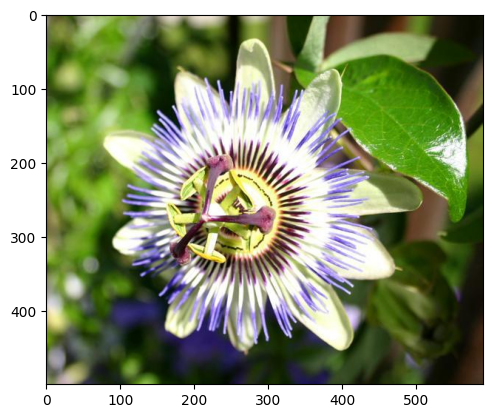

In [6]:
plt.imshow(img)

In [7]:
tf = transforms.Compose(
    [ transforms.ToTensor(), transforms.Resize([64,64]), transforms.RandomVerticalFlip(0.1),transforms.RandomHorizontalFlip(0.1) ] ) # добален ресайз и повороты


TypeError: Image data of dtype object cannot be converted to float

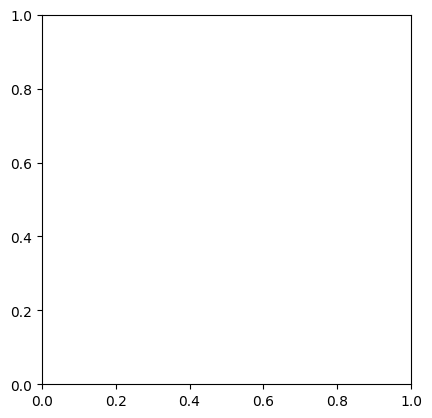

In [14]:
plt.imshow()

In [23]:
img2 = transforms.ToPILImage(tf(img))

In [24]:
img2()

ToPILImage(mode=tensor([[[0.4713, 0.3612, 0.3303,  ..., 0.0510, 0.0471, 0.0586],
         [0.4819, 0.4325, 0.4566,  ..., 0.0533, 0.0392, 0.0510],
         [0.4315, 0.5035, 0.5020,  ..., 0.0510, 0.0392, 0.0544],
         ...,
         [0.3814, 0.4403, 0.4069,  ..., 0.1991, 0.2352, 0.2894],
         [0.3987, 0.4070, 0.6296,  ..., 0.1975, 0.2468, 0.2928],
         [0.5027, 0.5546, 0.7540,  ..., 0.2070, 0.2504, 0.2774]],

        [[0.4512, 0.3526, 0.3801,  ..., 0.0588, 0.0549, 0.0665],
         [0.4841, 0.4499, 0.4779,  ..., 0.0611, 0.0471, 0.0588],
         [0.4642, 0.5464, 0.5529,  ..., 0.0588, 0.0471, 0.0623],
         ...,
         [0.4039, 0.4387, 0.4064,  ..., 0.1216, 0.1452, 0.1878],
         [0.4332, 0.4146, 0.5882,  ..., 0.1197, 0.1628, 0.2087],
         [0.5482, 0.5553, 0.6758,  ..., 0.1322, 0.1759, 0.2029]],

        [[0.3465, 0.1714, 0.1239,  ..., 0.0078, 0.0039, 0.0155],
         [0.3314, 0.2081, 0.2126,  ..., 0.0101, 0.0000, 0.0078],
         [0.2619, 0.2262, 0.2314,  ..., 0.

In [26]:
trans = transforms.ToPILImage()

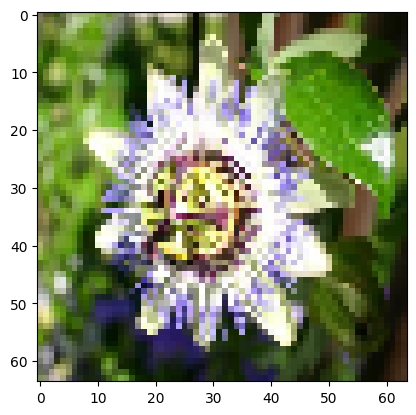

In [30]:
plt.imshow(trans(tf(img)))